In [1]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm as tqdm
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


## Что мы прошли на прошлых 2 занятиях

### Тесты для гипотезы сравнения средних 
- Параметрические тесты: 
    - z-тест
    - t-тест
    
### Тесты для гипотез относительно распределения выборок 
- Непараметрические тесты:
    - Колмогорова-Cмирнова (сравнение выборки с известным распределением)
    - Колмогорова-Cмирнова (сравнение выборки с классом распределений)
        - поправки с помощью симуляций ЭФР статистики Колмогорова
        - встроенные поправки Лиллифорса (from statsmodels.stats.diagnostic import lilliefors) для нормального и экспоненциального распределений
    - Тест Шапиро-Уилка (сравнение выборки с классом нормальных распределений)

--- 
### Синтетические АА-тесты для проверки валидности критерия
- на полностью синтетической модели данных
- на исторических данных 
    - независимые сегменты данных (например, разбиение по неделям и гео)
    - шаффлинг одного и того же датасета (проблема: зависимость выборок)

По большому количеству синтетических экспериментов без эффекта: 
- Много раз считаем pvalue
- Пользуемся знанием, что pvalue должно быть равномерно распределено при $H_0$
    - Визуальное подтверждение: 
        - Гистограмма p-value
        - QQ-плот 
        - ЭФР 
    - Тест Колмогорова-Смирнова на то, что выборка из $U[0,1]$
    - Оценка ошибки I рода, доверительный интервал для ошибки I рода

In [2]:
def proportion_ci(pvalue_vector, alpha=0.05):
    pvalue_vector = np.asarray(pvalue_vector).flatten()
    n = len(pvalue_vector)
    count = np.sum(pvalue_vector < alpha)
    p = count / n
    left_bound = p - np.sqrt(p * (1 - p) / n) * stats.norm.ppf(1-alpha/2)
    right_bound = p + np.sqrt(p * (1 - p) / n) * stats.norm.ppf(1-alpha/2)
    return p, left_bound, right_bound

def plot_comparison_with_uniform(p_value_vector, title, color='skyblue'):
    # Предполагаем, что функция proportion_ci определена отдельно
    p, left_boundary, right_boundary = proportion_ci(p_value_vector)
    print(f"Ошибка I рода: {round(p, 4)},\nCI для oшибки I рода: [{round(left_boundary, 4)}, {round(right_boundary, 4)}]")

    fig1, ax1 = plt.subplots(1, 3, figsize=(17, 5))
    
    # --- 1. Гистограмма P-value ---
    ax1[0].hist(p_value_vector, bins=30, edgecolor='black', alpha=0.7, color=color)
    ax1[0].set_title(
        f'Ошибка I рода: {round(np.sum(np.array(p_value_vector) < 0.05) / len(p_value_vector), 3)}'
    )
    ax1[0].set_xlabel('P-value')
    ax1[0].set_ylabel('Частота')
    
    # --- 2. QQ-график ---
    stats.probplot(p_value_vector, dist=stats.uniform, plot=ax1[1])
    ax1[1].get_lines()[1].set_linestyle('--')
    ax1[1].set_title(f'{title} (QQ-график)')
    
    # --- 3. Эмпирическая функция распределения ---
    pvals_sorted = np.sort(p_value_vector)
    n = len(pvals_sorted)
    ecdf = np.arange(1, n+1) / n

    x_uniform = np.linspace(0, 1, 200)
    cdf_uniform = x_uniform

    ax1[2].step(pvals_sorted, ecdf, where='post', label='Эмпирическая ФР', color=color)
    ax1[2].plot(x_uniform, cdf_uniform, 'k--', label='Теоретическая CDF $U[0,1]$')
    
    # --- Тест Колмогорова-Смирнова ---
    ks_statistic, ks_p_value = stats.kstest(p_value_vector, 'uniform', args=(0, 1))
    print(f'Статистика Колмогорова-Смирнова: {round(ks_statistic, 4)}, pvalue для сравнения ЭФР с равномерным: {round(ks_p_value, 4)}')
    if ks_p_value < 0.05:
        print("Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)")
    else:
        print("Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)")
    
    ax1[2].set_title('Эмпирическая и теоретическая ФР')
    ax1[2].set_xlabel('p-value')
    ax1[2].set_ylabel('F(p-value)')
    ax1[2].legend(loc="lower right")
    ax1[2].text(
        0.05, 0.9,
        f"KS: stat={ks_statistic:.3f}\np={ks_p_value:.3f}",
        transform=ax1[2].transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle="round", fc="w", alpha=0.5)
    )

    plt.tight_layout()
    plt.show()
    
def group_sample_gen(mu_exp=500, mu_pois=3, n=1000):
    noise_factors = [0.8, 0.9, 1, 1.1, 1.2]
    test_event = []
    test_user = []
    for i in range(n):
        k_test = np.random.poisson(lam=mu_pois)
        noise_test = [random.choice(noise_factors) for _ in range(k_test)]
        test_temp = [np.random.exponential(mu_exp)] * k_test
        test_event = test_event + [a * b for a, b in zip(noise_test, test_temp)]
        test_user = test_user + [sum([a * b for a, b in zip(noise_test, test_temp)])]
    return test_user

## 2.1 Как сравнить два критерия? 

Какой критерий лучше для наших данных? 

- Валидность критерия определяется на ошибках I рода (на АА тестах)
- Качество критерия проверятеся на ошибках II рода (на синтетических AB тестах)

То есть берется модель данных и добавляется искусственно эффект. 


1. Наблюдение = событие (<span style="color: red;">плохо:</span>  есть зависимость в данных)

2. Наблюдения = как-то агрегированные события

<img src="pictures/agg.png" width="300" align="left">

> **Поюзерная агрегация** - агрегация (типа сумма) до пользователя, то есть один пользователь - одно наблюдение

> **Побакетная агрегация** - бакетизация (sharding, bucketization) — это агрегирование пользователей (или событий) по группам ("бакетам") и дальнейшая работа на уровне этих групп, а не индивидуальных пользователей.  

- Фиксируется число бакетов, например, 200
- Пользователи случайно раскидываются по бакету
- Внутри бакета считается целевая метрика

## 2.2 Сравнение критериев между собой: валидность критерия 

На примере поюзерной и побакетной агрегации 

In [3]:
def make_buckets_vec(sample, agg_type, n_buckets=100):
    
    N_users = len(sample)
    buckets = [[] for _ in range(n_buckets)]
    for idx in range(N_users):
        bucket_num = idx % n_buckets
        buckets[bucket_num].append(idx)  # индекс пользователя
    
    random.shuffle(sample)
    bucket_vec = []
    for idxs in buckets:
        if agg_type == 'sum':
            vec = np.sum([sample[i] for i in idxs], axis=0)
        else:
            vec = np.mean([sample[i] for i in idxs], axis=0)
        bucket_vec.append(vec)
    return bucket_vec

In [4]:
pvalue_tt_user = []
pvalue_tt_backet = []
for i in tqdm(range(1000)):
    test_user = group_sample_gen(mu_exp=500, mu_pois=3, n=1000)
    control_user  = group_sample_gen(mu_exp=500, mu_pois=3, n=1000)
    test_backet = make_buckets_vec(test_user, agg_type = 'sum', n_buckets=100)
    control_backet = make_buckets_vec(control_user, agg_type = 'sum', n_buckets=100)
    _, p_value_user = stats.ttest_ind(test_user, control_user, equal_var=False)
    _, p_value_backet = stats.ttest_ind(test_backet, control_backet, equal_var=False)
    pvalue_tt_backet.append(p_value_backet)
    pvalue_tt_user.append(p_value_user)

100%|██████████| 1000/1000 [00:32<00:00, 30.61it/s]


Ошибка I рода: 0.047,
CI для oшибки I рода: [0.0339, 0.0601]
Статистика Колмогорова-Смирнова: 0.0253, pvalue для сравнения ЭФР с равномерным: 0.537
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


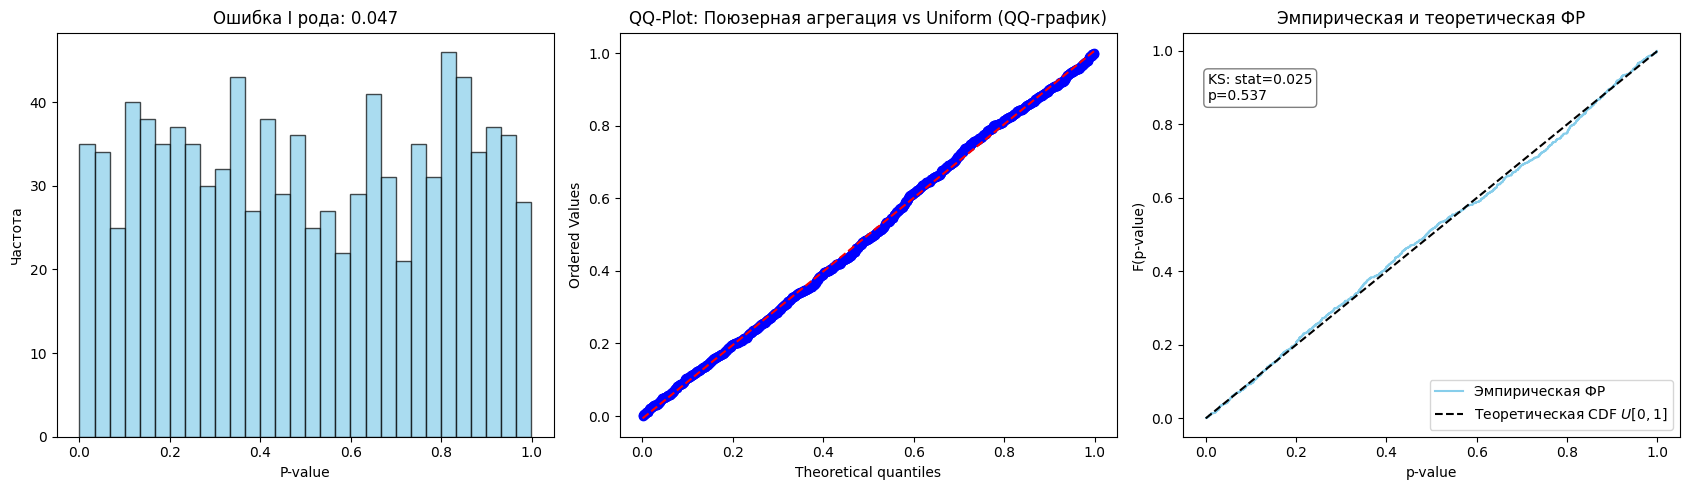

In [5]:
plot_comparison_with_uniform(pvalue_tt_user, 'QQ-Plot: Поюзерная агрегация vs Uniform')

Ошибка I рода: 0.049,
CI для oшибки I рода: [0.0356, 0.0624]
Статистика Колмогорова-Смирнова: 0.0272, pvalue для сравнения ЭФР с равномерным: 0.4431
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


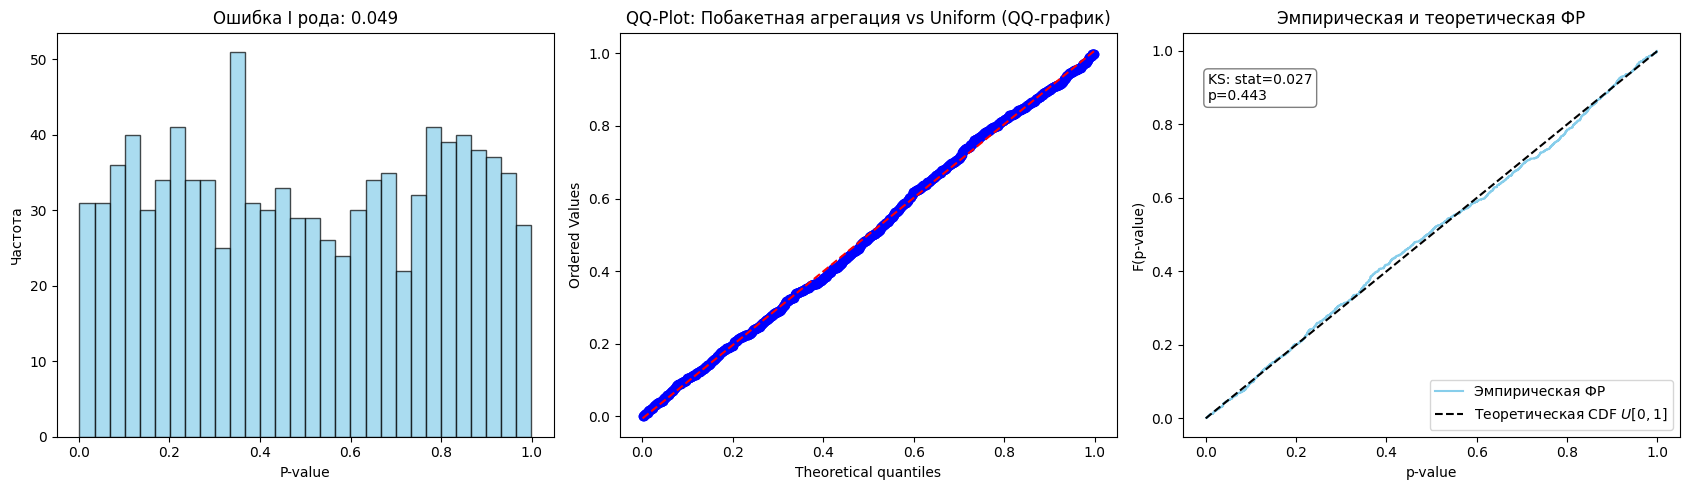

In [6]:
plot_comparison_with_uniform(pvalue_tt_backet, 'QQ-Plot: Побакетная агрегация vs Uniform')

## 2.3 Сравнение критериев между собой: мощность критерия 

Искусственно добавляем эффект
- к каждому значению тестовой выборки (абсолютный, процентный)
- к матожиданию

In [8]:
pvalue_tt_user_eff = []
pvalue_tt_backet_eff = []
effect = 0.05
for i in tqdm(range(1000)):
    test_user = group_sample_gen(mu_exp=500*(1+effect), mu_pois=3, n=1000)
    control_user  = group_sample_gen(mu_exp=500, mu_pois=3, n=1000)
    test_backet = make_buckets_vec(test_user, agg_type = 'sum', n_buckets=100)
    control_backet = make_buckets_vec(control_user, agg_type = 'sum', n_buckets=100)
    _, p_value_user = stats.ttest_ind(np.array(test_user), np.array(control_user), equal_var=False)
    _, p_value_backet = stats.ttest_ind(np.array(test_backet), np.array(control_backet), equal_var=False)
    pvalue_tt_backet_eff.append(p_value_backet)
    pvalue_tt_user_eff.append(p_value_user)

100%|██████████| 1000/1000 [00:32<00:00, 30.77it/s]


Ошибка I рода: 0.138,
CI для oшибки I рода: [0.1166, 0.1594]
Статистика Колмогорова-Смирнова: 0.1734, pvalue для сравнения ЭФР с равномерным: 0.0
Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)


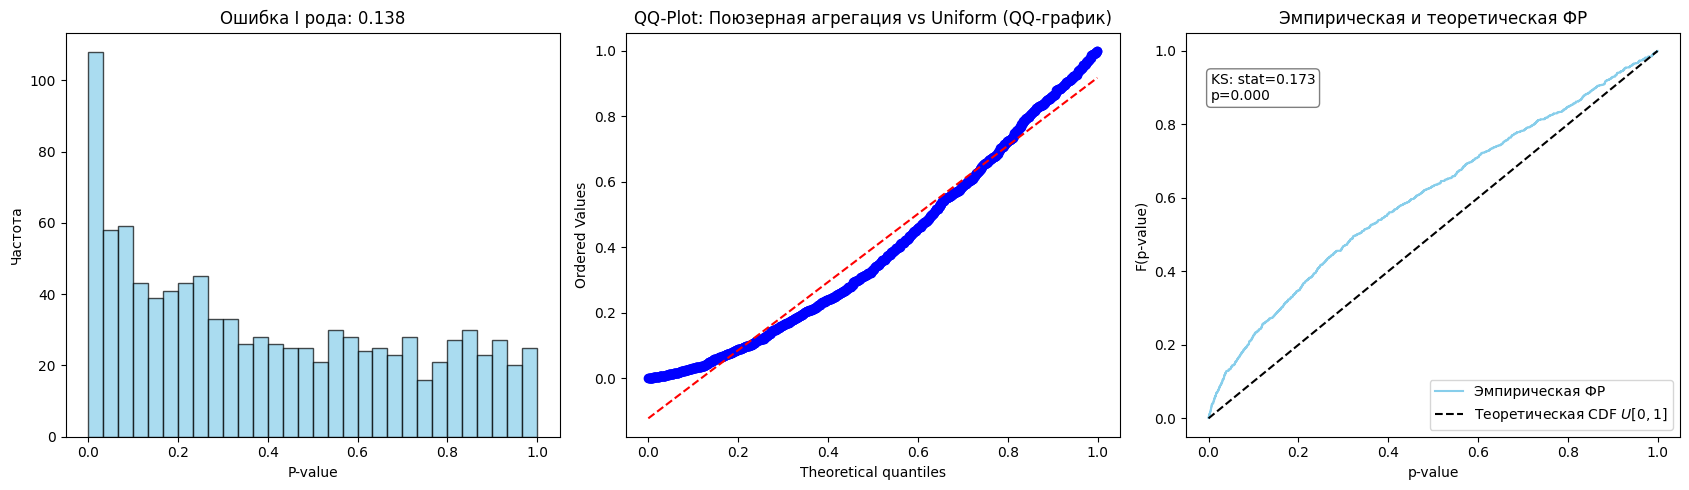

In [9]:
plot_comparison_with_uniform(pvalue_tt_user_eff, 'QQ-Plot: Поюзерная агрегация vs Uniform')

Ошибка I рода: 0.136,
CI для oшибки I рода: [0.1148, 0.1572]
Статистика Колмогорова-Смирнова: 0.1744, pvalue для сравнения ЭФР с равномерным: 0.0
Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)


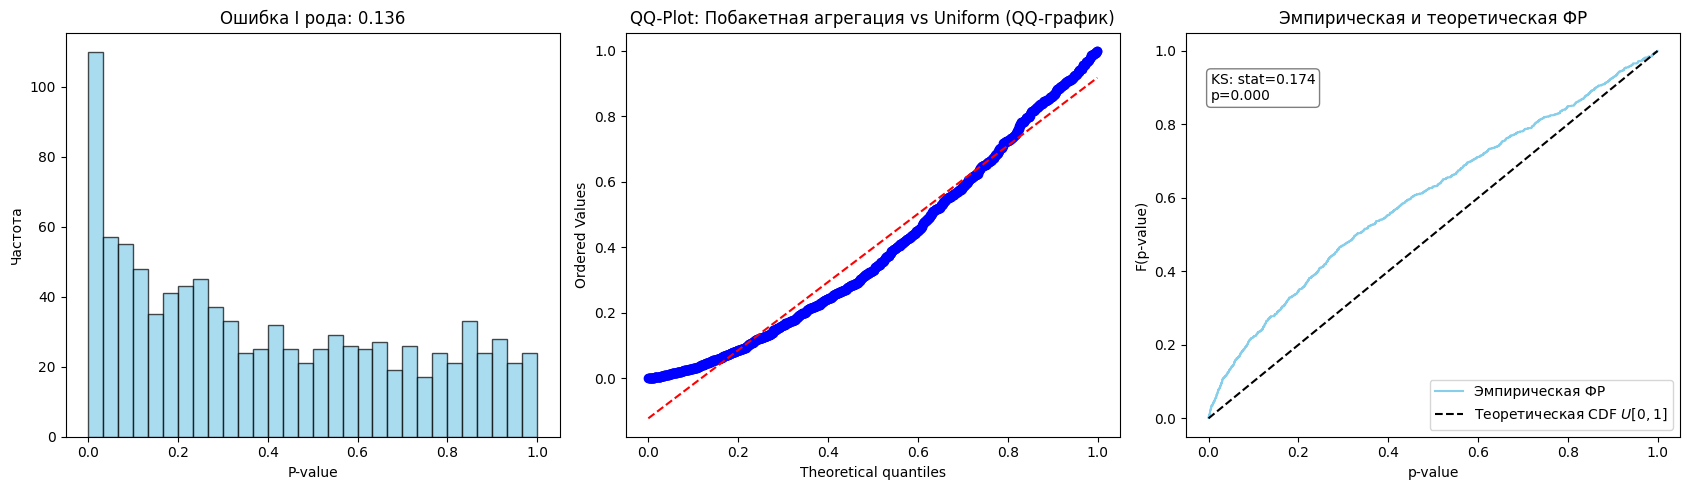

In [10]:
plot_comparison_with_uniform(pvalue_tt_backet_eff, 'QQ-Plot: Побакетная агрегация vs Uniform')

## А теперь построим мощность в зависимости от  n 



In [11]:
n_list = [10, 30, 60, 100, 200, 500, 1000, 2000, 5000]
effect = 0.05
n_sim = 1000
power_user = []
power_bucket = []

for n in n_list:
    pvalue_tt_user_eff = []
    pvalue_tt_bucket_eff = []
    for _ in tqdm(range(n_sim), desc=f"n={n}"):
        test_user = group_sample_gen(mu_exp=500*(1+effect), mu_pois=3, n=n)
        control_user  = group_sample_gen(mu_exp=500, mu_pois=3, n=n)
        test_bucket = make_buckets_vec(test_user, agg_type='sum', n_buckets=100)
        control_bucket = make_buckets_vec(control_user, agg_type='sum', n_buckets=100)
        _, p_value_user = stats.ttest_ind(np.array(test_user), np.array(control_user), equal_var=False)
        _, p_value_bucket = stats.ttest_ind(np.array(test_bucket), np.array(control_bucket), equal_var=False)
        pvalue_tt_user_eff.append(p_value_user)
        pvalue_tt_bucket_eff.append(p_value_bucket)
    # "Мощность" — доля p-value < 0.05
    power_user.append(np.mean(np.array(pvalue_tt_user_eff) < 0.05))
    power_bucket.append(np.mean(np.array(pvalue_tt_bucket_eff) < 0.05))


n=5000: 100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


In [12]:
for n, p_u, p_b in zip(n_list, power_user, power_bucket):
    print(f"n={n:<5}  user_ttest_power={p_u:.3f}   bucket_ttest_power={p_b:.3f}")

n=10     user_ttest_power=0.029   bucket_ttest_power=0.003
n=30     user_ttest_power=0.042   bucket_ttest_power=0.008
n=60     user_ttest_power=0.053   bucket_ttest_power=0.029
n=100    user_ttest_power=0.054   bucket_ttest_power=0.054
n=200    user_ttest_power=0.060   bucket_ttest_power=0.057
n=500    user_ttest_power=0.081   bucket_ttest_power=0.086
n=1000   user_ttest_power=0.135   bucket_ttest_power=0.144
n=2000   user_ttest_power=0.242   bucket_ttest_power=0.237
n=5000   user_ttest_power=0.461   bucket_ttest_power=0.458


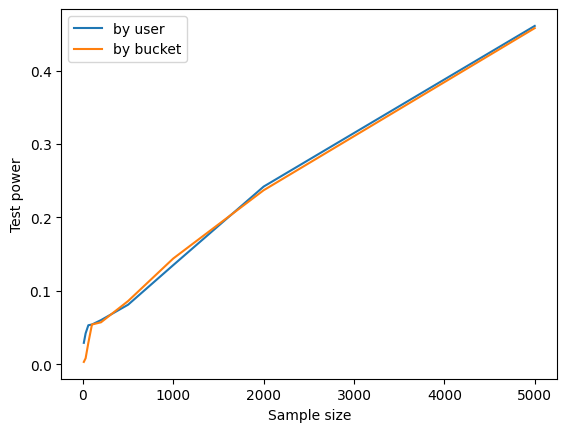

In [13]:
plt.plot(n_list, power_user, label='by user')
plt.plot(n_list, power_bucket, label='by bucket')
plt.xlabel('Sample size')
plt.ylabel('Test power')
plt.legend()
plt.show()

## 2.4 Сравнение поюзерной и побакетной агрегации

---

### Плюсы бакетизации относительно поюзерной агрегации

1. Решение проблемы неравномерности и аномалий
   - Бакетизация снижает влияние "жирных"/аномальных пользователей (например, если на одного пользователя приходится очень много событий).
   - Группировка "усредняет" метрику по бакету, делая ее распределение ближе к нормальному (центральная предельная теорема сильнее работает на бакетах).

2. Меньшая чувствительность к heavy users
   - Если есть единичные пользователи с огромным вкладом, их влияние на итоговую статистику существенно уменьшается.

3. Ускорение вычислений
   - Сильно экономится объем данных: вместо миллионов пользователей — сотни или тысячи бакетов, что упрощает анализ (особенно при сервисах-агрегаторах или больших таблицах).

---

### Минусы бакетизации относительно поюзерной агрегации

1. Потеря информации
   - Бакетирование — это дополнительное сглаживание, которое может "размазать" аномалии, искажения и нюансы распределения (например, пропадет информация о дисперсии внутри бакета).
   - Потери в точности оценки дисперсий, поскольку наблюдений становится сильно меньше, особенно при небольшом числе бакетов.

2. Может стать менее чувствительным
   - Мощность статистических тестов может снижаться, поскольку уменьшается количество независимых наблюдений (их теперь = число бакетов, а не число пользователей).
   - Особенно плохо при маленьких тестовых выборках.
   
3. Неравномерность группы теста и контроля
   - Если внутри бакета агрегация типа 'sum', то при неравномерном разбиении все ломается
   - Если внутри бакета агрегация типа 'mean', то дальше тест работает для сравнения средних от средних, что не очень понятно что значит с точки зрения бизнеса 

3. Сложность подбора числа бакетов
   - Если бакетов слишком мало — статистика "грубеет", если слишком много — многие бакеты получаются пустыми.

4. Проблемы с балансом
   - При некорректной генерации бакетов возможна компрометация рандомизации (бакеты могут содержать перекошенное распределение по группам).

5. Не всегда применимо
   - Если требуется анализ на уровне отдельных пользователей (например, сегментация), бакетизация затруднит анализ.

---

### Синтетическая модель данных при проверке мощности критерия
...

## 3.1 Метрики отношения: дельта-метод, линеаризация, бутстрап, бакеты
Метрики отношения: 

1. **Acceptance Rate (or AR)**: Отношение количества принятых кандидатом предложений о заказе (офферов) к количеству увиденных кандидатом предложений о заказе


2. **Completed Rate (or CR)**: Отношение суммарного количества поездок к суммарному количеству заказов с назначенным исполнителем. Отражает вероятность того, что заказ будет успешно выполнен.


3. **Trips per hours**: Количество уникальных успешно выполненных заказов к суммарному количеству часов, когда водитель готов принимать заказы (статус 'free') или выполняет заказ (статусы 'waiting', 'driving', 'transporting')


4. Классические **конверсии**: пришел, увидел, победил

### На какой вопрос хочет уметь отвечать бизнес? 

Как изменилось ГЛОБАЛЬНОЕ отношение по сервису. 
$$\dfrac{\sum \limits_{e} X(e)}{\sum \limits_{e} Y(e)} = \dfrac{\sum \limits_{u} X(u)}{\sum \limits_{u} Y(u)},$$
где 
- $e$ – наблюдение или событие 

- $u$ – пользователь 

- $X(e), Y(e)$ – значения числителя и знаменателя метрики для конкретного события 

- $X(u), Y(u)$ – поюзерные значения числителя и знаменателя метрики (агрегация типа SUM)

Заметим, что 
$$\frac{\sum \limits_{u} X(u)}{\sum \limits_{u} Y(u)} = \frac{\overline X}{\overline Y}$$

Наша статистическая гипотеза в таком случае выглядит так: 

$$H_0: \frac{\overline X_t}{\overline Y_t} = \frac{\overline X_c}{\overline Y_c}$$

### Какой статистический критерий использовать?
 
 t-test, z-test умеет работать только с одним вектором данных. А у нас их 2. 
 
## 3.2 Есть ли у конверсии шанс? А у пособытийных средних?

Кажется с метрикой конверсии все попроще, например, метрика конверсии в клик устроена так: 
каждый пользователь генерирует 

- событие показа рекламы (1) (знаменатель)
- событие клика (0, 1) (числитель)

И можно было бы рассматривать только числитель и гипотезу сравнения средних (просто средние будут браться по observations, а не по users). 

Аналогично для средней длины сессии, средниго чека и пр. метрик...


<div class="alert-success">
Можем ли мы использовать классические статистические критерии в этом случае?
</div>

Синтетические данные для метрики средний чек за поездку:

- Будем считать, что чек за поездку распределен np.random.exponential(mu_exp)
- Количество поездок, которое генерируеет пользователь за целевой период, будет моделировать с помощью np.random.poisson(1)

In [14]:
def event_sample(num_users = 10000, events_per_user = 5):
    # матожидание чека для пользователя, вектор длинны количества пользователей 
    mu = np.random.uniform(300, 1000, size=num_users)
    # число наблюдений по пользователю,ве ктор длинны количества пользователей 
    n = np.random.poisson(events_per_user-1, size=num_users)
    events = []
    averages = []

    for i in range(num_users):
        # Генерация экспоненциальных случайных чисел для текущего пользователя
        user_events = np.random.exponential(mu[i], n[i]+1)
        # Добавление событий текущего пользователя в общий список событий
        events.extend(user_events)
        averages.append(np.mean(user_events))

    return events, averages 

In [15]:
pvalue_tt_events = []
global_avg = []
user_avg = []
#симулируем 1000 раз, сохраняя значение pvalue 
for i in tqdm(range(1000)):
    test_group_event, test_group_avg = event_sample()
    control_group_event, control_group_avg = event_sample()
    global_avg.append(np.mean(test_group_event) - np.mean(control_group_event))
    user_avg.append(np.mean(test_group_avg) - np.mean(control_group_avg))
    t_stat, p_value = stats.ttest_ind(test_group_event, control_group_event, equal_var=False)
    pvalue_tt_events.append(p_value)

100%|██████████| 1000/1000 [05:08<00:00,  3.25it/s]


Ошибка I рода: 0.084,
CI для oшибки I рода: [0.0668, 0.1012]
Статистика Колмогорова-Смирнова: 0.0745, pvalue для сравнения ЭФР с равномерным: 0.0
Гипотеза H0 отвергается: выборка НЕ из равномерного U(0,1)


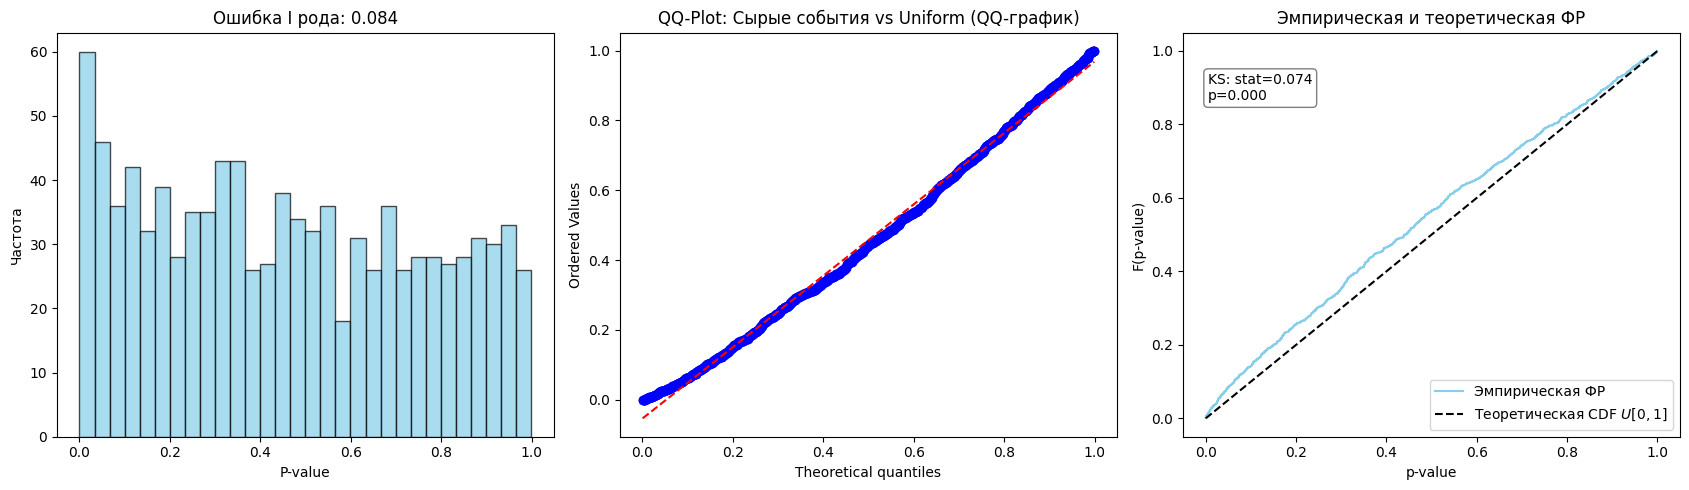

In [16]:
plot_comparison_with_uniform(pvalue_tt_events, 'QQ-Plot: Cырые события vs Uniform')

<div class="alert-danger">
Вывод: Статистический критерий не работает. Чем больше событий генерирует пользователь, тем хуже работает критерий. </div>

## 3.3 А если посчитать поюзерное отношение? И тем самым получить поюзерный вектор для ttest. 

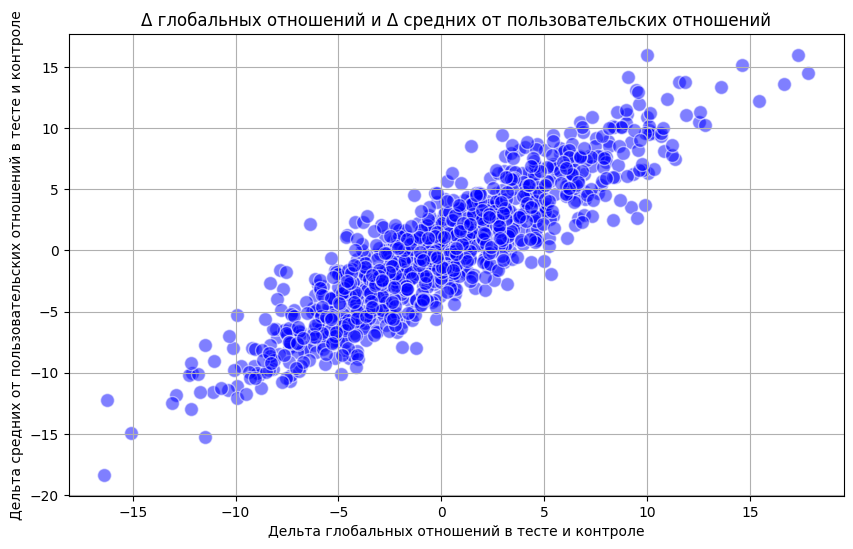

In [17]:
# Построение графика точек
plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
plt.scatter(global_avg, user_avg, c='blue', alpha=0.5, edgecolors='w', s=100)
plt.title('Δ глобальных отношений и Δ средних от пользовательских отношений')
plt.xlabel('Дельта глобальных отношений в тесте и контроле')
plt.ylabel('Дельта средних от пользовательских отношений в тесте и контроле')
plt.grid(True)

# Отображение графика
plt.show()

## 3.4 Первое очевидное решение: bootstrap

Бутстрап (bootstrap) — мощный непараметрический метод оценки характеристик распределения статистик (например, среднего, разницы средних, медианы и др.) с помощью повторного случайного выбора (выборки с возвращением) из исходных данных. В АB-тестах бутстрап позволяет строить доверительные интервалы и получать p-value без строгих предположений о виде распределения данных.

### Как работает бутстрап в анализе А/Б-тестов

### 1. Процедура бутстрапа


У вас есть две группы (А — контроль, B — тест), и вы хотите узнать есть ли между ними статистически значимое различие по некоторой метрике (например, средний чек, конверсия, вовлечённость).

#### Пусть даны:
- $\{X^t_1, X^t_2, ..., X^t_{n}\}$ — значения метрики в группе А.
- $\{X^c_1, X^c_2, ..., X^c_{m}\}$ — значения метрики в группе B.
#### Алгоритм (на примере разницы средних):

1. Считаем наблюдаемую разницу:  
   $\Delta_{obs} = \bar{X^t} - \bar{X^c}$

2. Создаём $B$ бутстрап-выборок (обычно $B=1000-10000$):
   - Для каждой итерации $i$:
     - Фиксируем выборку с возвращением из $X^t$ длины $n$
     - Фиксируем выборку с возвращением из $X^c$ длины $m$
     - Считаем разницу средних $\Delta_i^*$

3. Получаем распределение $\Delta^*$  
   Массив из $B$ значений разницы средних.

4. Строим доверительный интервал  
   - Например, 95% ДИ — это 2.5-й и 97.5-й перцентили в массиве $\Delta^*$.
   - Если ноль входит в доверительный интервал, различие незначимо.


Каждый элемент попадает в бутстрап-выборку с вероятностью $1 - (1-1/n)^n ≈ 1 - 1/e \approx 63\%$. 

### 2. **Пуассоновский бутстрап (Poisson bootstrap)**
**Пуассоновский бутстрап (Poisson bootstrap)** — это разновидность классического бутстрапа, где вместо выборки с возвращением (resampling with replacement) применяется случайное включение каждого элемента исходной выборки в бутстрап-выборку такое число раз, которое определяется случайной величиной из пуассоновского распределения с математическим ожиданием 1.

Алгоритм Poisson bootstrap:

1. Для каждой бутстрап-выборки:
    - Для каждого наблюдения $i$ исходной выборки:
        - Сгенерируйте $w_i \sim Poisson(\lambda=1)$
        - Включите наблюдение $w_i$ раз в бутстрап-выборку (или, что то же самое, используйте вес $w_i$ для этого наблюдения при подсчёте статистики)
2. Рассчитайте интересующую статистику (например, среднее, медиану и т.д.) с учетом этих весов (или с повторяющимися наблюдениями, что эквивалентно).

### Применение пуассоновского бутстрапа

- Большие данные: Можно эффективно распараллеливать (каждая "машина" может генерить свои веса независимо, не пересылая данные по сети).
- MapReduce и Spark: Популярно в больших распределённых системах.

ВАЖНО!!!
- в бутстрапе на самом деле сэмплируются пользователи, а не метрики
- то есть для ratio метрики $X(u), Y(u)$ одновременно попадают в числитель и знаменатель с нужным весом (количество повторений $w_i$)

Бутстрап очень дорогой метод. Так что всегда ищите альтернативы. 

In [18]:
def ratio_sample(num_users = 10000, events_per_user = 5):
    # матожидание чека для пользователя, вектор длинны количества пользователей 
    mu = np.random.uniform(300, 1000, size=num_users)
    # число наблюдений по пользователю,ве ктор длинны количества пользователей 
    n = np.random.poisson(events_per_user-1, size=num_users)
    numerator = []
    denominator = []

    for i in range(num_users):
        # Генерация экспоненциальных случайных чисел для текущего пользователя
        user_events = np.random.exponential(mu[i], n[i]+1)
        # Добавление событий текущего пользователя в общий список событий
        numerator.append(np.sum(np.array(user_events)))
        denominator.append(n[i]+1)

    return numerator, denominator

In [19]:
def safe_divide(x, y):
    try:
        return x / y
    except ZeroDivisionError:
        return np.nan

In [38]:
def boot(x_num, x_denom, y_num, y_denom, alpha = 0.05, n_iterations = 1000): 
    metrics = []
    for _ in range(n_iterations):
        x_weights = np.random.poisson(1, size = len(x_num))  
        y_weights = np.random.poisson(1, size= len(y_num)) 
    
        boot_x_num = np.repeat(x_num, x_weights)
        boot_x_denom = np.repeat(x_denom, x_weights)
        boot_y_num = np.repeat(y_num, y_weights)
        boot_y_denom = np.repeat(y_denom, y_weights)
        x = safe_divide(np.sum(boot_x_num),np.sum(boot_x_denom))
        y = safe_divide(np.sum(boot_y_num),np.sum(boot_y_denom))
        metrics.append(x-y)
    left = np.percentile(np.array(metrics), 100*alpha/2)
    right = np.percentile(np.array(metrics), 100*(1 - alpha/2))
    is_sig = 1
    if left*right < 0:
        is_sig = 0
    return is_sig

In [39]:
B = 1000
bad_cnt = 0
for i in tqdm(range(B)):
    x_num, x_denom = ratio_sample(1000, 2)
    y_num, y_denom = ratio_sample(1000, 2)

    is_sig = boot(x_num, x_denom, y_num, y_denom)
    bad_cnt += is_sig
p = bad_cnt/B
left = p - np.sqrt(p * (1 - p) / B) * np.abs(stats.norm.ppf(0.05))
right = p + np.sqrt(p * (1 - p) / B) * np.abs(stats.norm.ppf(0.05))
print(f'Ошибка I рода: {p}, CI: ({left}, {right})')

100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]

Ошибка I рода: 0.058, CI: (0.04584187217710074, 0.07015812782289926)


## 3.5 Бакеты

- Разбиваем пользователей по бакетам
- В каждом бакете считаем отношение
- А дальше t-тест. 

Что такое среднее от побакетных отношений? 

## 3.6 Дельта-метод простыми словами 
---
Есть случайная величина $ \Delta =  \dfrac{ \bar X_t}{ \bar Y_t}  - \dfrac{ \bar X_c}{ \bar Y_c} $, при ВЕРНОСТИ $H_0$ хотим понять как она РАСПРЕДЕЛЕНА, какая у нее ДИСПЕРСИЯ (МАТОЖИДАНИЕ по условию 0).

---

**Одномерный дельта-метод**:

Если последовательность случайных величин $X_n$ сходится по распределению к $\sqrt{n}[X_n - \mu]  \xrightarrow{\text{d}} \mathcal{N}(0, \sigma^2)$, где $\mu$ и $\sigma$ — конечные константы, то для любой $g(t)$ — непрерывной и дифференцируемой трансформации, такой что $g'(\mu) \neq 0$, имеем  

$$\sqrt{n}[g(X_n) - g(\mu)]  \xrightarrow{\text{d}} \mathcal{N}(0, \sigma^2\cdot g'(\mu)^2)$$


---

Доказательство:

Мы используем разложение функции $g(t)$ в ряд Тейлора в окрестности точки $\mu$:

$$ g(X_n) \approx g(\mu) + g'(\mu) (X_n-\mu).$$ 

Тогда математическое ожидание и дисперсия будут равны

$E[g(X_n)] \approx g(\mu) + g'(\mu) E[X_n-\mu] = g(\mu)$ 

и 

$\text{Var}[g(X_n)] \approx 0 + g'(\mu)^2 (\text{Var}X_n - 0) = \sigma^2 \cdot g'(\mu)^2$.



### Многомерное обобщение
 Этот способ хорошо обобщается на многомерный случай: 
 
 $$ \mathcal{D}[g(X_n, Y_n, ...)] \approx \nabla g(\mu_{X_1}, \mu_{X_2}, ...)^T  \mathbf{\Sigma} \nabla g(\mu_{X_1}, \mu_{X_2}, ...), $$  
 
где $\mathbf{\Sigma}$ - матрица ковариации 

$\nabla$ - градиент.

### Дельта-метод для $\dfrac{X}{Y}$

Пусть у нас есть две случайные величины $\mathbf{X}$ (числитель) и $\mathbf{Y}$ (знаменатель).

При этом
$$
X - \mu_X \xrightarrow{d} N(0, \sigma_X^2) \quad \text{и} \quad Y - \mu_Y \xrightarrow{d} N(0, \sigma_Y^2)
$$

Возьмём функцию трансформации $g(X, Y) = \dfrac{X}{Y}$. Тогда градиент будет равен
$
\nabla g(X, Y) = 
\begin{bmatrix}
    \dfrac{1}{Y} \\
    -\dfrac{X}{Y^2}
\end{bmatrix}
$

Ковариационная матрица выглядит так:
$
\Sigma =
\begin{bmatrix}
    \sigma_X^2 & \sigma_{XY} \\
    \sigma_{XY} & \sigma_Y^2
\end{bmatrix}
$

$$
\mathrm{Var}\left(\frac{X}{Y}\right) \approx 
\frac{1}{\mu_Y^2} \cdot \sigma_X^2
- 2 \frac{\mu_X}{\mu_Y^3} \cdot \sigma_{XY}
+ \frac{\mu_X^2}{\mu_Y^4} \cdot \sigma_Y^2 =
$$

$$
=
\frac{1}{\mu_Y^2}\cdot\sigma_X^2 
- \frac{\mu_X}{\mu_Y^3}\cdot \sigma_{XY}
- \frac{\mu_X}{\mu_Y^3}\cdot \sigma_{XY}
+ \frac{\mu_X^2}{\mu_Y^4}\cdot\sigma_Y^2
=
$$

$$
=
\frac{1}{\mu_Y^2}\cdot\sigma_X^2 
- 2\frac{\mu_X}{\mu_Y^3}\cdot \sigma_{XY}
+ \frac{\mu_X^2}{\mu_Y^4}\cdot\sigma_Y^2
$$


ИЛИ 

$\dfrac{X}{Y} \approx \dfrac{\mu_X}{\mu_Y} + \dfrac{1}{\mu_Y}(X - \mu_X) -\dfrac{\mu_X}{\mu_Y^2}(Y-\mu_Y) = \dfrac{\mu_X}{\mu_Y} + \dfrac{1}{\mu_Y}X - \dfrac{\mu_X}{\mu_Y^2}Y$


### Соберем все для $ \Delta =  \dfrac{ \bar X_t}{ \bar Y_t}  - \dfrac{ \bar X_c}{ \bar Y_c} $


$$
\mathrm{Var}\left(\frac{X}{Y}\right) \approx  \frac{1}{\mu_Y^2}\cdot\sigma_X^2 
- 2\frac{\mu_X}{\mu_Y^3}\cdot \sigma_{XY}
+ \frac{\mu_X^2}{\mu_Y^4}\cdot\sigma_Y^2
$$

$
\hat{\sigma}_{X}  = \dfrac{1}{{n-1}}\sum\limits_{i=1}^n{(X_i- \bar{X})^2}
$

$
\hat{\sigma}_{Y}  = \dfrac{1}{{n-1}}\sum\limits_{i=1}^n{(Y_i- \bar{Y})^2}
$

$
\hat{\sigma}_{XY}  = \dfrac{1}{{n-1}}\sum\limits_{i=1}^n{(X_i- \bar{X})(Y_i- \bar{Y})}
$

--- 

$\bar X \rightarrow X, \bar Y \rightarrow Y$


$\hat\mu_X = \hat\mu_\bar X = \bar X, \hat\mu_Y = \hat\mu_\bar Y = \bar Y$

$\hat\sigma^2_\bar X = \dfrac{\hat\sigma^2_X}{n}, \hat\sigma^2_\bar Y = \dfrac{\hat\sigma^2_Y}{n}$

$\hat\sigma_{\bar X \bar Y} = \dfrac{\hat\sigma_{XY}}{n} $


$$
\hat{\mathbf{Var}} (\dfrac{\bar X}{\bar Y} ) = \dfrac{1}{n} \dfrac{1}{\bar Y^2} \left[ \hat\sigma_X^2  - 2\dfrac{\bar X}{\bar Y}\hat\sigma_{XY} + \dfrac{\bar X^2}{\bar Y^2} \hat\sigma_Y^2 \right ]
$$

Пусть $R^t = \dfrac{\bar X^t}{\bar Y_t}, R^c = \dfrac{\bar X^c}{\bar Y_c}$

$$\hat{\mathbf{Var}}(R^t - R^c) = \hat{\mathbf{Var}}(R^t) + \hat{\mathbf{Var}}(R^c)$$

$$\hat\sigma =  \sqrt{\hat{\mathbf{Var}} (\dfrac{\bar X_t}{\bar Y_t})  + \hat{\mathbf{Var}} (\dfrac{\bar X_c}{\bar Y_c}) } $$

Статистика эксперимента будет 

$$\dfrac{\dfrac{\bar X_t}{\bar Y_t} - \dfrac{\bar X_c}{\bar Y_c}}{\sqrt{\hat{\mathbf{Var}} (\dfrac{\bar X_t}{\bar Y_t})  + \hat{\mathbf{Var}} (\dfrac{\bar X_c}{\bar Y_c}) }}$$

In [40]:
def delta_var(numerator, denominator):
    """
    Функция для расчета дисперсии дельта-методом, numerator - вектор числитель, denominator - вектор знаменатель
    """
    x = numerator
    y = denominator
    n = len(x)
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]    
    delta_var = safe_divide(safe_divide(var_x,mu_y**2)  - 2*cov_xy*safe_divide(mu_x,mu_y**3) + var_y*safe_divide(mu_x**2,mu_y**4), n)
    return delta_var



In [23]:
num = 1000
pvalue_tt_delta = []
for i in tqdm(range(num)):
    x_num, x_denom = ratio_sample(10000, 2)
    y_num, y_denom = ratio_sample(10000, 2)
    n = len(x_num)
    m = len(y_num)
    test_var = delta_var(x_num, x_denom)
    control_var = delta_var(y_num, y_denom)
    sigma = np.sqrt(test_var + control_var)
    delta_estimator = safe_divide(np.mean(x_num), np.mean(x_denom)) - safe_divide(np.mean(y_num), np.mean(y_denom))
    tt = safe_divide(delta_estimator, sigma)
    pvalue = 2*stats.t.sf(np.abs(tt),n+m-2)
    pvalue_tt_delta.append(pvalue)

100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]


Ошибка I рода: 0.052,
CI для oшибки I рода: [0.0382, 0.0658]
Статистика Колмогорова-Смирнова: 0.0269, pvalue для сравнения ЭФР с равномерным: 0.4569
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


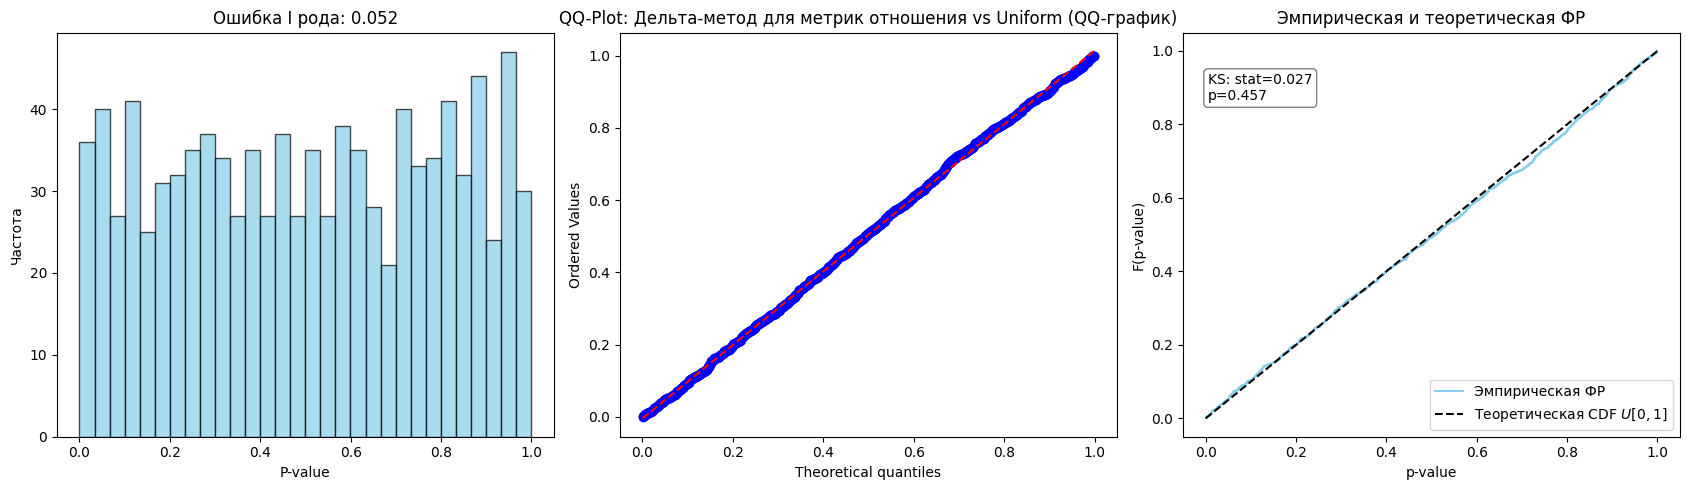

In [24]:
plot_comparison_with_uniform(pvalue_tt_delta, 'QQ-Plot: Дельта-метод для метрик отношения vs Uniform')

### ЛИНЕАРИЗАЦИЯ. Тип 1

$L(u) = X(u) - R^c Y(u)$

где 

$R^c$ - значие метрики отношения в контроле. 

$\text{sgn} \Delta(R^t - R^c) = \text{sgn}  \Delta(\bar L^t - \bar L^c)$, то есть есть сонаправленность. 


$\bar L = \bar X - R^c \bar Y = \bar Y(\dfrac{\bar X}{\bar Y} - R^c)$

$\bar L^t = \bar Y^t(R^t - R^c), \, \bar L^c = 0$

$$\bar L^t - \bar L^c  = \bar Y^t(R^t - R^c)$$

[Ссылка на статью](https://www.researchgate.net/profile/Roman-Budylin/publication/322969314_Consistent_Transformation_of_Ratio_Metrics_for_Efficient_Online_Controlled_Experiments/links/5b054bbb45851588c6d4a1aa/Consistent-Transformation-of-Ratio-Metrics-for-Efficient-Online-Controlled-Experiments.pdf)

### ЛИНЕАРИЗАЦИЯ. Тип 2

Разложение в ряд Тейлора для непрерывной трансформации $g(X, Y) = \frac{X}{Y}$ в окрестности матожидания: 

$\dfrac{X}{Y} \approx \dfrac{\mu_X}{\mu_Y} + \dfrac{1}{\mu_Y}(X - \mu_X) -\dfrac{\mu_X}{\mu_Y^2}(Y-\mu_Y) = \dfrac{\mu_X}{\mu_Y} + \dfrac{1}{\mu_Y}X - \dfrac{\mu_X}{\mu_Y^2}Y$

$L(u) = \dfrac{\bar X}{\bar Y} + \dfrac{1}{\bar Y} X(u) - \dfrac{\bar X}{\bar Y^2} Y(u) = R +  \dfrac{1}{\bar Y}(X(u) - R Y(u))$.


$$\frac{\bar X}{\bar Y} \approx \frac{1}{n}\sum_{u} \left(\dfrac{\mu_X}{\mu_Y} + \dfrac{1}{\mu_Y}X(u) - \dfrac{\mu_X}{\mu_Y^2} Y(u) \right) \stackrel{d}{\rightarrow} \bar L$$


In [60]:
def linearization_type_1(x_num, x_denom, y_num, y_denom):
    n = len(x_num)
    m = len(y_num)
    x_num_bar = np.mean(x_num)
    y_num_bar = np.mean(y_num)
    x_denom_bar = np.mean(x_denom)
    y_denom_bar = np.mean(y_denom)
    x_estimator = safe_divide(x_num_bar, x_denom_bar)
    y_estimator = safe_divide(y_num_bar, y_denom_bar)
    delta_estimator = x_estimator - y_estimator
    x_linear = np.array(x_num) - y_estimator*np.array(x_denom)
    y_linear = np.array(y_num) - y_estimator*np.array(y_denom)
    t_stat, p_value = stats.ttest_ind(x_linear, y_linear, equal_var=False)
    is_sig = 1
    if p_value > 0.05:
        is_sig = 0
    return  is_sig

def linearization_type_2(x_num, x_denom, y_num, y_denom):
    n = len(x_num)
    m = len(y_num)
    x_num_bar = np.mean(x_num)
    y_num_bar = np.mean(y_num)
    x_denom_bar = np.mean(x_denom)
    y_denom_bar = np.mean(y_denom)
    x_estimator = safe_divide(x_num_bar, x_denom_bar)
    y_estimator = safe_divide(y_num_bar, y_denom_bar)
    delta_estimator = x_estimator - y_estimator
    x_linear = x_estimator  + safe_divide(1, x_denom_bar)*(np.array(x_num) - x_estimator*np.array(x_denom))
    y_linear = y_estimator  + safe_divide(1, y_denom_bar)*(np.array(y_num) - y_estimator*np.array(y_denom))
    t_stat, p_value = stats.ttest_ind(x_linear, y_linear, equal_var=False)
    is_sig = 1
    if p_value > 0.05:
        is_sig = 0
    return  is_sig

In [27]:
pvalue_linearization_type_1 = []
pvalue_linearization_type_2 = []
for i in tqdm(range(1000)):
    x_num, x_denom = ratio_sample(10000, 2)
    y_num, y_denom = ratio_sample(10000, 2)
    pvalue_linearization_type_1.append(linearization_type_1(x_num, x_denom, y_num, y_denom))
    pvalue_linearization_type_2.append(linearization_type_2(x_num, x_denom, y_num, y_denom))

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]


Ошибка I рода: 0.058,
CI для oшибки I рода: [0.0435, 0.0725]
Статистика Колмогорова-Смирнова: 0.0295, pvalue для сравнения ЭФР с равномерным: 0.3438
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


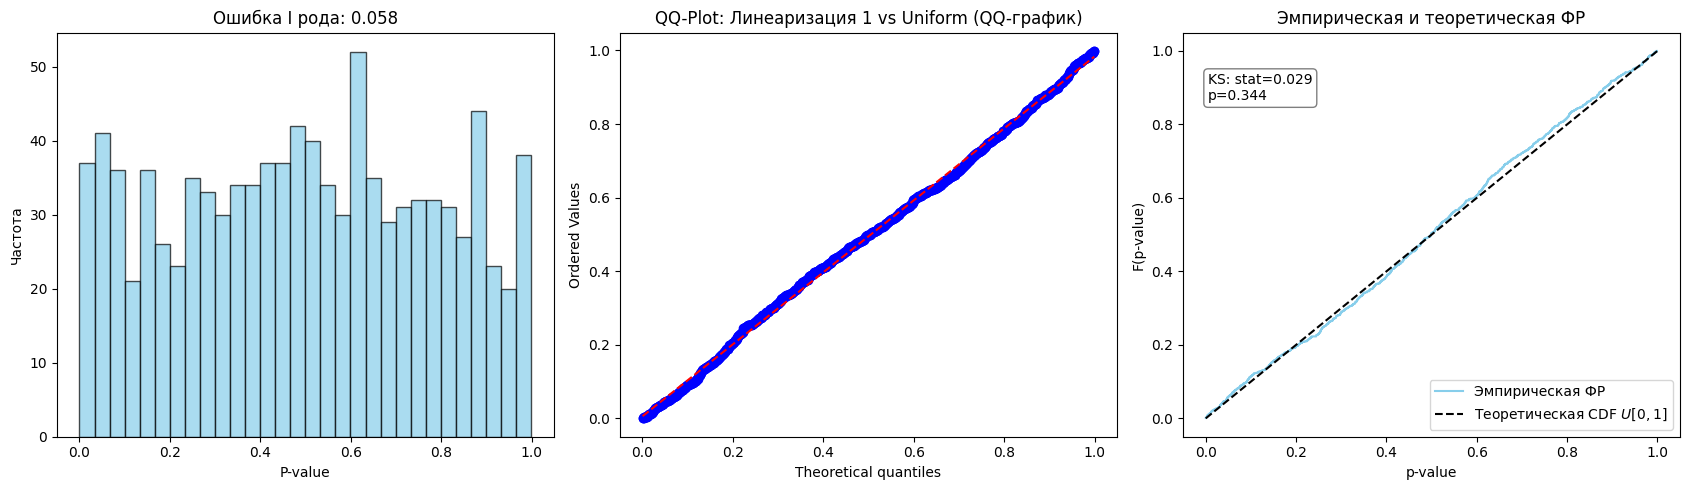

In [28]:
plot_comparison_with_uniform(pvalue_linearization_type_1, 'QQ-Plot: Линеаризация 1 vs Uniform')

Ошибка I рода: 0.058,
CI для oшибки I рода: [0.0435, 0.0725]
Статистика Колмогорова-Смирнова: 0.0291, pvalue для сравнения ЭФР с равномерным: 0.3602
Нет оснований отвергнуть H0: выборка МОГЛА быть из U(0,1)


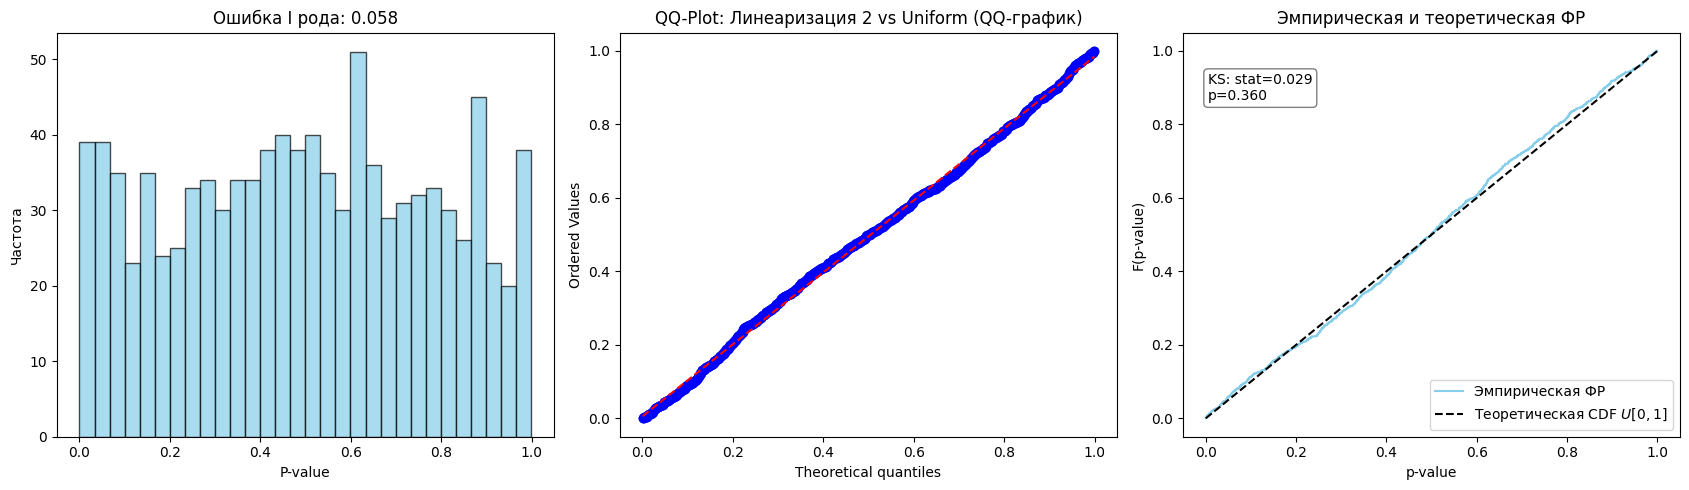

In [29]:
plot_comparison_with_uniform(pvalue_linearization_type_2, 'QQ-Plot: Линеаризация 2 vs Uniform')

## Сравнение критериев между собой

In [61]:
def ratio_sample(num_users = 10000, events_per_user = 5, effect = 0):
    # матожидание чека для пользователя, вектор длинны количества пользователей 
    mu = np.random.uniform(300, 1000, size=num_users)
    # число наблюдений по пользователю,ве ктор длинны количества пользователей 
    n = np.random.poisson(events_per_user-1, size=num_users)
    numerator = []
    denominator = []

    for i in range(num_users):
        # Генерация экспоненциальных случайных чисел для текущего пользователя
        user_events = np.random.exponential(mu[i], n[i]+1)
        # Добавление событий текущего пользователя в общий список событий
        numerator.append((1+effect)*np.sum(np.array(user_events)))
        denominator.append(n[i]+1)

    return numerator, denominator

def buckets(x_num, x_denom, y_num, y_denom, n_buckets=100):
    
    n = len(x_num)
    m = len(y_num)
    
    buckets_test = [[] for _ in range(n_buckets)]
    for idx in range(n):
        bucket_num = idx % n_buckets
        buckets_test[bucket_num].append(idx)  
    
    buckets_control = [[] for _ in range(n_buckets)]
    for idx in range(m):
        bucket_num = idx % n_buckets
        buckets_control[bucket_num].append(idx) 
    
    bucket_vec_test = []
    for idxs in buckets_test:
        vec = np.sum([x_num[i] for i in idxs], axis=0) / np.sum([x_denom[i] for i in idxs], axis=0)
        bucket_vec_test.append(vec)

    bucket_vec_control = []
    for idxs in buckets_control:
        vec = np.sum([y_num[i] for i in idxs], axis=0) / np.sum([y_denom[i] for i in idxs], axis=0)
        bucket_vec_control.append(vec)
    t_stat, p_value = stats.ttest_ind(bucket_vec_test, bucket_vec_control, equal_var=False)
    is_sig = 1
    if p_value > 0.05:
        is_sig = 0
    return  is_sig

def delta_method(x_num, x_denom, y_num, y_denom):
    n = len(x_num)
    m = len(y_num)
    test_var = delta_var(x_num, x_denom)
    control_var = delta_var(y_num, y_denom)
    sigma = np.sqrt(test_var + control_var)
    delta_estimator = safe_divide(np.mean(x_num), np.mean(x_denom)) - safe_divide(np.mean(y_num), np.mean(y_denom))
    tt = safe_divide(delta_estimator, sigma)
    p_value = 2*stats.t.sf(np.abs(tt),n+m-2)
    is_sig = 1
    if p_value > 0.05:
        is_sig = 0
    return  is_sig

In [62]:
good_cnt_linear_1 = []
good_cnt_linear_2 = []
good_cnt_bucket = []
good_cnt_delta = []
good_cnt_boot = []
for n in [100, 500, 1000]:
    cnt_linear_1 = 0
    cnt_linear_2 = 0
    cnt_bucket = 0
    cnt_delta = 0
    cnt_boot = 0
    for i in tqdm(range(1000)):
        x_num, x_denom = ratio_sample(n, 2, effect = 0.05)
        y_num, y_denom = ratio_sample(n, 2)
        cnt_linear_1 += linearization_type_1(x_num, x_denom, y_num, y_denom)
        cnt_linear_2 += linearization_type_2(x_num, x_denom, y_num, y_denom)
        cnt_bucket += buckets(x_num, x_denom, y_num, y_denom, n_buckets=100)
        cnt_delta += delta_method(x_num, x_denom, y_num, y_denom)
        cnt_boot += boot(x_num, x_denom, y_num, y_denom, alpha = 0.05, n_iterations = 1000)
    good_cnt_linear_1.append(cnt_linear_1/1000)
    good_cnt_linear_2.append(cnt_linear_2/1000)
    good_cnt_bucket.append(cnt_bucket/1000)
    good_cnt_delta.append(cnt_delta/1000)
    good_cnt_boot.append(cnt_boot/1000)

100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]


In [64]:
for n in [2000]:
    cnt_linear_1 = 0
    cnt_linear_2 = 0
    cnt_bucket = 0
    cnt_delta = 0
    cnt_boot = 0
    for i in tqdm(range(1000)):
        x_num, x_denom = ratio_sample(n, 2, effect = 0.05)
        y_num, y_denom = ratio_sample(n, 2)
        cnt_linear_1 += linearization_type_1(x_num, x_denom, y_num, y_denom)
        cnt_linear_2 += linearization_type_2(x_num, x_denom, y_num, y_denom)
        cnt_bucket += buckets(x_num, x_denom, y_num, y_denom, n_buckets=100)
        cnt_delta += delta_method(x_num, x_denom, y_num, y_denom)
        cnt_boot += boot(x_num, x_denom, y_num, y_denom, alpha = 0.05, n_iterations = 1000)
    good_cnt_linear_1.append(cnt_linear_1/1000)
    good_cnt_linear_2.append(cnt_linear_2/1000)
    good_cnt_bucket.append(cnt_bucket/1000)
    good_cnt_delta.append(cnt_delta/1000)
    good_cnt_boot.append(cnt_boot/1000)

100%|██████████| 1000/1000 [11:10<00:00,  1.49it/s]


In [65]:
for n in [5000]:
    cnt_linear_1 = 0
    cnt_linear_2 = 0
    cnt_bucket = 0
    cnt_delta = 0
    cnt_boot = 0
    for i in tqdm(range(1000)):
        x_num, x_denom = ratio_sample(n, 2, effect = 0.05)
        y_num, y_denom = ratio_sample(n, 2)
        cnt_linear_1 += linearization_type_1(x_num, x_denom, y_num, y_denom)
        cnt_linear_2 += linearization_type_2(x_num, x_denom, y_num, y_denom)
        cnt_bucket += buckets(x_num, x_denom, y_num, y_denom, n_buckets=100)
        cnt_delta += delta_method(x_num, x_denom, y_num, y_denom)
        cnt_boot += boot(x_num, x_denom, y_num, y_denom, alpha = 0.05, n_iterations = 1000)
    good_cnt_linear_1.append(cnt_linear_1/1000)
    good_cnt_linear_2.append(cnt_linear_2/1000)
    good_cnt_bucket.append(cnt_bucket/1000)
    good_cnt_delta.append(cnt_delta/1000)
    good_cnt_boot.append(cnt_boot/1000)

100%|██████████| 1000/1000 [27:33<00:00,  1.65s/it]


In [66]:
for n in [10000]:
    cnt_linear_1 = 0
    cnt_linear_2 = 0
    cnt_bucket = 0
    cnt_delta = 0
    cnt_boot = 0
    for i in tqdm(range(1000)):
        x_num, x_denom = ratio_sample(n, 2, effect = 0.05)
        y_num, y_denom = ratio_sample(n, 2)
        cnt_linear_1 += linearization_type_1(x_num, x_denom, y_num, y_denom)
        cnt_linear_2 += linearization_type_2(x_num, x_denom, y_num, y_denom)
        cnt_bucket += buckets(x_num, x_denom, y_num, y_denom, n_buckets=100)
        cnt_delta += delta_method(x_num, x_denom, y_num, y_denom)
        cnt_boot += boot(x_num, x_denom, y_num, y_denom, alpha = 0.05, n_iterations = 1000)
    good_cnt_linear_1.append(cnt_linear_1/1000)
    good_cnt_linear_2.append(cnt_linear_2/1000)
    good_cnt_bucket.append(cnt_bucket/1000)
    good_cnt_delta.append(cnt_delta/1000)
    good_cnt_boot.append(cnt_boot/1000)

100%|██████████| 1000/1000 [55:14<00:00,  3.31s/it]


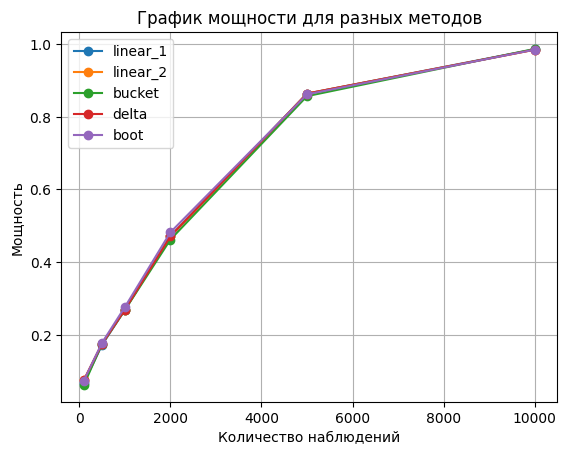

In [67]:
n = [100, 500, 1000, 2000, 5000, 10000]

plt.plot(n, good_cnt_linear_1, marker='o', label='linear_1')
plt.plot(n, good_cnt_linear_2, marker='o', label='linear_2')
plt.plot(n, good_cnt_bucket, marker='o', label='bucket')
plt.plot(n, good_cnt_delta, marker='o', label='delta')
plt.plot(n, good_cnt_boot, marker='o', label='boot')

plt.xlabel('Количество наблюдений')
plt.ylabel('Мощность')
plt.title('График мощности для разных методов')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
n = [100, 500, 1000, 2000, 5000, 10000]

df = pd.DataFrame({
    'linear_1': good_cnt_linear_1,
    'linear_2': good_cnt_linear_2,
    'bucket': good_cnt_bucket,
    'delta': good_cnt_delta,
    'boot': good_cnt_boot
}, index=n)

df.index.name = 'n'
print(df)

       linear_1  linear_2  bucket  delta   boot
n                                              
100       0.068     0.075   0.062  0.075  0.074
500       0.172     0.175   0.175  0.175  0.178
1000      0.268     0.269   0.268  0.269  0.276
2000      0.472     0.471   0.462  0.471  0.482
5000      0.864     0.864   0.857  0.864  0.862
10000     0.986     0.985   0.987  0.985  0.985
